<a href="https://colab.research.google.com/github/YifanSong348/STATS302/blob/main/Week%202/Weekly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#STATS302 HW 2 - Yifan Song
###Problem 2. Linear Discriminant Analysis (A)

In [23]:
import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, KFold
from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.utils import resample
from sklearn import metrics

# Load StatsModels API
# Note that if we wish to use R-style formulas, then we would use the StatsModels Formula API
import statsmodels.api as sm
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import files
import io

In [3]:
# import dataset
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['Weekly.csv']))
# df = data.drop(data.columns[0], axis=1)
print(df.shape)
df.head()

Saving Weekly.csv to Weekly.csv
(1089, 9)


,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up


# **a. Numerical and graphical summaries**

In [4]:
df.describe()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
count,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000,1089.000000
mean,2000.048669,0.150585,0.151079,0.147205,0.145818,0.139893,1.574618,0.149899
std,6.033182,2.357013,2.357254,2.360502,2.360279,2.361285,1.686636,2.356927
min,1990.000000,-18.195000,-18.195000,-18.195000,-18.195000,-18.195000,0.087465,-18.195000
25%,1995.000000,-1.154000,-1.154000,-1.158000,-1.158000,-1.166000,0.332022,-1.154000
50%,2000.000000,0.241000,0.241000,0.241000,0.238000,0.234000,1.002680,0.241000
75%,2005.000000,1.405000,1.409000,1.409000,1.409000,1.405000,2.053727,1.405000
max,2010.000000,12.026000,12.026000,12.026000,12.026000,12.026000,9.328214,12.026000


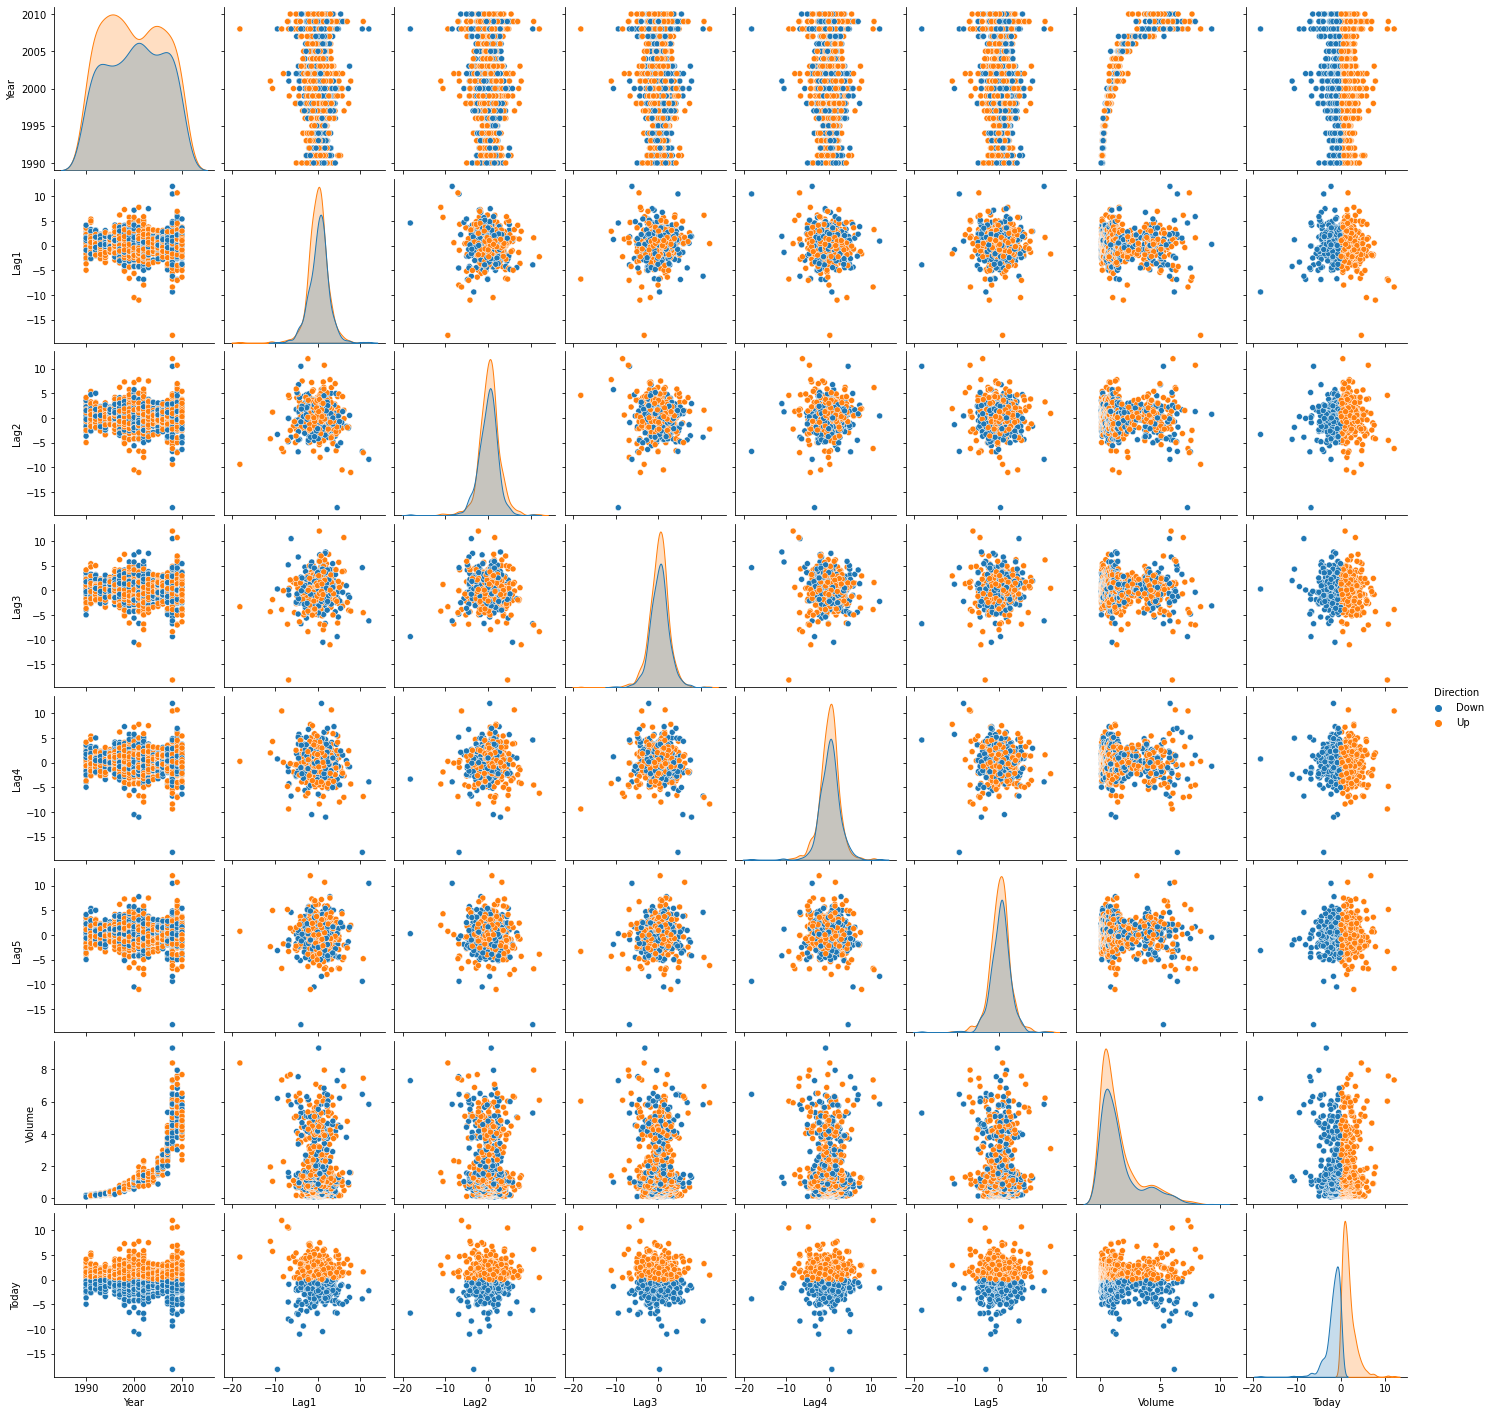

In [5]:
sns.pairplot(df, hue = "Direction");

From the initial summary statistics and scatterplot matrix, there don't appear to be any obvious patterns aside from the fact the volume of shares traded each week has grown quite a lot from 1990 to 2010.

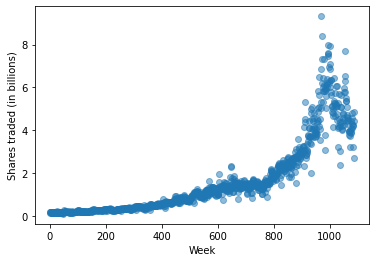

In [6]:
#fig = plt.figure(figsize = (10, 8))
ax = plt.axes()
ax.scatter(x = df.index, y = df["Volume"], alpha = 0.5)
ax.set(xlabel = "Week", ylabel = "Shares traded (in billions)");

Looking more closely at the scatterplot of just volume over time, we can see that the number of shares traded each week has grown exponentially over the 21 years covered by the data.

In [7]:
df.corr()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today
Year,1.000000,-0.032289,-0.033390,-0.030006,-0.031128,-0.030519,0.841942,-0.032460
Lag1,-0.032289,1.000000,-0.074853,0.058636,-0.071274,-0.008183,-0.064951,-0.075032
Lag2,-0.033390,-0.074853,1.000000,-0.075721,0.058382,-0.072499,-0.085513,0.059167
Lag3,-0.030006,0.058636,-0.075721,1.000000,-0.075396,0.060657,-0.069288,-0.071244
Lag4,-0.031128,-0.071274,0.058382,-0.075396,1.000000,-0.075675,-0.061075,-0.007826
Lag5,-0.030519,-0.008183,-0.072499,0.060657,-0.075675,1.000000,-0.058517,0.011013
Volume,0.841942,-0.064951,-0.085513,-0.069288,-0.061075,-0.058517,1.000000,-0.033078
Today,-0.032460,-0.075032,0.059167,-0.071244,-0.007826,0.011013,-0.033078,1.000000


Lastly, we look at the matrix of correlations between the variables. Looking at the last row, we can see that each of the lag variables is only correlated very weakly with today's returns. The sole substantial value of 0.842, between Volume and Year, which aligns with the strong correlation we saw in the above scatterplot.

# **b. Full dataset logistic regression**

In [31]:
X = df[["Lag1", "Lag2", "Lag3", "Lag4", "Lag5", "Volume"]]
X = sm.add_constant(X)
y = (df['Direction'] == "Up").astype("int64")
results = sm.Logit(y,X).fit()
print(results.summary())

Optimization terminated successfully.
         Current function value: 0.682441
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:              Direction   No. Observations:                 1089
Model:                          Logit   Df Residuals:                     1082
Method:                           MLE   Df Model:                            6
Date:                Tue, 06 Apr 2021   Pseudo R-squ.:                0.006580
Time:                        15:20:25   Log-Likelihood:                -743.18
converged:                       True   LL-Null:                       -748.10
Covariance Type:            nonrobust   LLR p-value:                    0.1313
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2669      0.086      3.106      0.002       0.098       0.435
Lag1          -0.0413      0.

In [11]:
pd.DataFrame({"Estimate": results.params, "Std. Error": results.bse, "z value": results.tvalues, "Pr(>|z|)": results.pvalues})

,Estimate,Std. Error,z value,Pr(>|z|)
const,0.266864,0.085930,3.105613,0.001899
Lag1,-0.041269,0.026410,-1.562610,0.118144
Lag2,0.058442,0.026865,2.175384,0.029601
Lag3,-0.016061,0.026663,-0.602376,0.546924
Lag4,-0.027790,0.026463,-1.050141,0.293653
Lag5,-0.014472,0.026385,-0.548501,0.583348
Volume,-0.022742,0.036898,-0.616333,0.537675


The only statistically significant predictor is Lag2, with a p-value of 0.0296 providing evidence at the 5% significance level to reject the null hypothesis that it is not related to the response Direction. None of the other predictors are statistically significant, though Lag1 is somewhat near the border of being significant at the 10% level, with a p-value of 0.1181.

# **c. Confusion matrix and overall fraction of correct predictions**

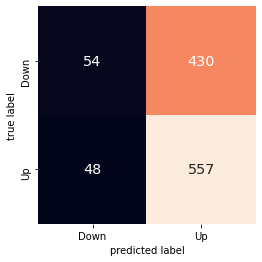

In [12]:
mat = pd.DataFrame(results.pred_table(), columns = ["Down", "Up"], index = ["Down", "Up"])
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"})
ax.set(xlabel = "predicted label", ylabel = "true label");

In [14]:
logit_preds = pd.Series(results.predict()).apply(lambda x: "Up" if (x > 0.5) else "Down")
(logit_preds == df["Direction"]).mean()

0.5610651974288338

As we can see in the confusion matrix, the logistic regression model using the five lag variables along with Volume as the predictors, and a prediction threshold of 0.5, correctly predicted 54 down weeks out of a total of 484 actual down weeks and 557 up days out of a total of 605 actual up weeks. This means that the model correctly predicted the direction for 611 weeks out of the 1089 for an accuracy of 0.5611. While this seems to be better than random chance, it is important to note that the model was trained on the entire data set, so 0.5611 is the training accuracy. Moreover, a naive strategy of simply saying that every week will be an up week would have resulted in 605 correctly predicted weeks out of 1089, which is a very similar level of overall accuracy.

To look a little closer at the confusion matrix, let's assume that our goal is to correctly predict when the market will go up. In this case, up weeks will be considered as positive ( + ) and down weeks as negative ( − ). Having set this convention, we can now consider four important quantities associated with the confusion matrix: true positive rate (i.e. sensitivity or recall), false positive rate, positive predictive value (i.e. precision), and negative predictive value. The true positive rate is the number of correctly predicted positives divided by the overall number of positives -- the number of correctly predicted up weeks (557) over the total number of up weeks (605) for a value of  557/605≈0.92  for this model. While this is a pretty high value, which is good, the false positive rate -- the number of incorrectly predicted positives (weeks incorrectly predicted to be up weeks = 430 weeks) divided by the overall number of negatives (the total number of down weeks = 484 weeks) -- is comparably high at  430/484≈0.888 , which might be quite bad depending on our sensitivity to losing money on an incorrectly predicted down week. Next is the positive predictive value, which is the number of true positives divided by the total number of predicted positives; in our case this is  557/987≈0.564 . This is better than chance, but as already noted we would have a comparable positive predictive value if we just predicted that every week would be an up week. Lastly is the negative predictive value, which is the number of true negatives divided by the total number of predicted negatives; in our case this is  54/102≈0.529.

# **d. Training data (1990 to 2008) logistic regression, with Lag2 as the only predictor. Compute the confusion matrix and the overall fraction of correct predictions for the held out data (2009 to 2010)**

In [15]:
train_mask = (df["Year"] < 2009)
train_endog = (df.loc[train_mask, "Direction"] == "Up").astype("int64")
train_exog = sm.add_constant(df.loc[train_mask, "Lag2"])
logit_mod = sm.Logit(train_endog, train_exog)
logit_res = logit_mod.fit()
print(logit_res.summary())

Optimization terminated successfully.
         Current function value: 0.685555
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:              Direction   No. Observations:                  985
Model:                          Logit   Df Residuals:                      983
Method:                           MLE   Df Model:                            1
Date:                Tue, 06 Apr 2021   Pseudo R-squ.:                0.003076
Time:                        15:08:55   Log-Likelihood:                -675.27
converged:                       True   LL-Null:                       -677.35
Covariance Type:            nonrobust   LLR p-value:                   0.04123
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2033      0.064      3.162      0.002       0.077       0.329
Lag2           0.0581      0.

In [16]:
test_exog = sm.add_constant(df.loc[~train_mask, "Lag2"])
test_endog = df.loc[~train_mask, "Direction"]
logit_test_probs = logit_res.predict(test_exog)
logit_test_preds = pd.Series(logit_test_probs).apply(lambda x: "Up" if (x > 0.5) else "Down")

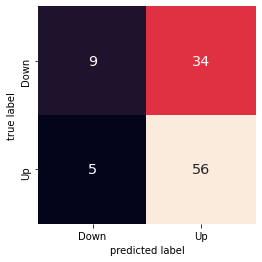

In [17]:
mat = pd.DataFrame(confusion_matrix(test_endog, logit_test_preds), columns = ["Down", "Up"], index = ["Down", "Up"])
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"})
ax.set(xlabel = "predicted label", ylabel = "true label");

In [20]:
(logit_test_preds == df.loc[~train_mask, "Direction"]).mean()

0.625

In [21]:
(df.loc[~train_mask, "Direction"] == "Up").mean()

0.5865384615384616

After fitting a logistic regression model on the data from 1990 through 2008 using only Lag2 as the predictor, the model correctly predicted the market direction for 62.5% of the weeks in the held-out data (the data from 2009 and 2010). While this is better than chance, it still is less than a 10% improvement over naively predicting that every week will be an up week. Continuing with the convention from Part 3 that an up week is a positive result, the true positive rate is  56/61≈0.918 , while the false positive rate is  34/43≈0.791 . In addition, the positive predictive value is  56/90≈0.622  and the negative predictive value is  9/14≈0.643 .

# **e. LDA**

In [37]:
# First separate out the training and test sets
X_train = df.loc[train_mask, "Lag2"].to_frame()
y_train = df.loc[train_mask, "Direction"]
X_test = df.loc[~train_mask, "Lag2"].to_frame()
y_test = df.loc[~train_mask, "Direction"]

# Fit the LDA model using the training set
lda_clf = LDA()
lda_clf.fit(X_train, y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

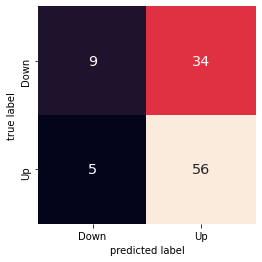

In [26]:
y_pred = lda_clf.predict(X_test)
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = lda_clf.classes_, yticklabels = lda_clf.classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [27]:
lda_clf.score(X_test, y_test)

0.625

After performing linear discriminant analysis on the data from 1990 through 2008 using only Lag2 as the predictor, we ended up with an identical confusion matrix to the one from Part 4 with the logistic regression model. As we saw in Part 4, the model correctly predicted the market direction for 62.5% of the weeks in the held-out data (the data from 2009 and 2010). While this is better than chance, it still is less than a 10% improvement over naively predicting that every week will be an up week. Continuing with the convention from Part 3 that an up week is a positive result, the true positive rate is  56/61≈0.918 , while the false positive rate is  34/43≈0.791 . In addition, the positive predictive value is  56/90≈0.622  and the negative predictive value is  9/14≈0.643 .

# **f. QDA**

In [28]:
# First separate out the training and test sets
X_train = df.loc[train_mask, "Lag2"].to_frame()
y_train = df.loc[train_mask, "Direction"]
X_test = df.loc[~train_mask, "Lag2"].to_frame()
y_test = df.loc[~train_mask, "Direction"]

# Fit the QDA model using the training set
qda_clf = QDA()
qda_clf.fit(X_train, y_train)

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)

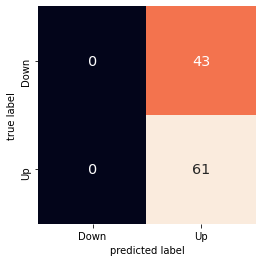

In [32]:
y_pred = qda_clf.predict(X_test)
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = qda_clf.classes_, yticklabels = qda_clf.classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [33]:
qda_clf.score(X_test, y_test)

0.5865384615384616

After performing quadratic discriminant analysis on the data from 1990 through 2008 using only Lag2 as the predictor, we ended up with a model that ended up predicting that every week in 2009 and 2010 would be an up week. The model correctly predicted the market direction for 58.7% of the weeks in the held-out data (the data from 2009 and 2010). While this is better than chance, it is the same result one would get from naively predicting that every week will be an up week, so to better compare the performance of this model to the logistic regression and linear discriminant analysis models testing on a larger test set would be necessary. Continuing with the convention from Part 3 that an up week is a positive result, the true positive rate is  61/61=1 , while the false positive rate is  43/43≈1 . In addition, the positive predictive value is  61/104≈0.587  and since there were no negative predictions discussing the negative predictive value is meaningless.

# **g. KNN (K = 1)**

In [34]:
# First separate out the training and test sets
X_train = df.loc[train_mask, "Lag2"].to_frame()
y_train = df.loc[train_mask, "Direction"]
X_test = df.loc[~train_mask, "Lag2"].to_frame()
y_test = df.loc[~train_mask, "Direction"]

# Set NumPy random seed for consistency and reproducibility of our results
np.random.seed(312)

# Fit the KNN model using the training set
knn_1_clf = KNeighborsClassifier(n_neighbors = 1)
knn_1_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

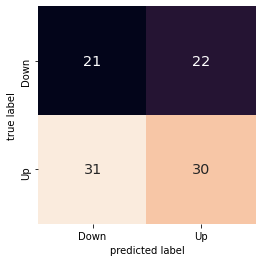

In [38]:
y_pred = knn_1_clf.predict(X_test)
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = qda_clf.classes_, yticklabels = qda_clf.classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [39]:
knn_1_clf.score(X_test, y_test)

0.49038461538461536

After performing  k -nearest neighbors classification with  k=1  on the data from 1990 through 2008 using only Lag2 as the predictor, the model correctly predicted the market direction for 49% of the weeks in the held-out data (the data from 2009 and 2010). While this essentially only as good as picking the direction randomly, it had worse performance than naively predicting that every week will be an up week. Continuing with the convention from Part 3 that an up week is a positive result, the true positive rate is  30/61≈0.492 , while the false positive rate is  22/43≈0.512 . In addition, the positive predictive value is  30/52≈0.577  and the negative predictive value is  21/52≈0.404 .

# **h. Which of these methods appears to provide the best results on this data?**

If we are only considering overall prediction accuracy, it appears that logistic regression and linear discriminant analysis were equally good as the models that performed the best on this data. Quadratic discriminant analysis came in third place, and  k -nearest neighbors with  k=1  a distant fourth. As noted above in Part 7,  k -nearest neighbors didn't perform any better than randomly guessing, and in fact performed worse than naively predicting every week would be an up week. One thing that I would be cautious of, though, is the fact that aside from KNN, the other three models very strongly preferred to predict up weeks, and therefore had high false positive rates. This might be okay for an investor who is comfortable with taking more risks and has can afford losing money to down weeks that were incorrectly predicted to be up weeks, but a risk-averse investor would probably want to use a less aggressive model, or at least require a higher probability threshold than 50% before accepting a prediction of an up week.

# **i. Experiment with different combinations of predictors, including possible transformations and interactions, for each of the methods. Report the variables, method, and associated confusion matrix that appears to provide the best results on the held out data.**

**Different combinations of predictors**


The combination of predictors I will try out is a weighted average of the lag variables where the recent lag values are weighted more heavily than the ones further in the past. More specifically, I will try out giving Lag1 a weight of 40%, Lag2 a weight of 35%, Lag3 a weight of 15%, and Lag4 and Lag5 each weights of 5%. 

In [40]:
weighted_lag_avg = 0.4*df["Lag1"] + 0.35*df["Lag2"] + 0.15*df["Lag3"] + 0.05*df["Lag4"] + 0.05*df["Lag5"]
df["weighted_lag_avg"] = weighted_lag_avg
df.head()

,Year,Lag1,Lag2,Lag3,Lag4,Lag5,Volume,Today,Direction,weighted_lag_avg
0,1990,0.816,1.572,-3.936,-0.229,-3.484,0.154976,-0.270,Down,0.10055
1,1990,-0.270,0.816,1.572,-3.936,-0.229,0.148574,-2.576,Down,0.20515
2,1990,-2.576,-0.270,0.816,1.572,-3.936,0.159837,3.514,Up,-1.12070
3,1990,3.514,-2.576,-0.270,0.816,1.572,0.161630,0.712,Up,0.58290
4,1990,0.712,3.514,-2.576,-0.270,0.816,0.153728,1.178,Up,1.15560


In [41]:
df[["Today", "weighted_lag_avg"]].corr()

,Today,weighted_lag_avg
Today,1.000000,-0.037241
weighted_lag_avg,-0.037241,1.000000


Computing the correlation between this weighted average and the value of the current week's return, we see that there only a very weak correlation between the two quantities. It is smaller in magnitude than the correlations between Today and the first the lag variables individually. That seems to suggest that this weighting might not be too useful, but I will still try out each of the classification methods using this transformation of the predictors. I will start out with logistic regression.

**Logistic Regression**

In [43]:
# Using the Logit class from StatsModels
# First encode response numerically
train_endog = (df.loc[train_mask, "Direction"] == "Up").astype("int64")
train_exog = sm.add_constant(df.loc[train_mask, "weighted_lag_avg"])
logit_mod = sm.Logit(train_endog, train_exog)
logit_res = logit_mod.fit()
print(logit_res.summary())

Optimization terminated successfully.
         Current function value: 0.687529
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:              Direction   No. Observations:                  985
Model:                          Logit   Df Residuals:                      983
Method:                           MLE   Df Model:                            1
Date:                Tue, 06 Apr 2021   Pseudo R-squ.:               0.0002054
Time:                        15:31:02   Log-Likelihood:                -677.22
converged:                       True   LL-Null:                       -677.35
Covariance Type:            nonrobust   LLR p-value:                    0.5978
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.2135      0.064      3.312      0.001       0.087       0.340
weighted_la

In [44]:
test_exog = sm.add_constant(df.loc[~train_mask, "weighted_lag_avg"])
test_endog = df.loc[~train_mask, "Direction"]
logit_test_probs = logit_res.predict(test_exog)
logit_test_preds = pd.Series(logit_test_probs).apply(lambda x: "Up" if (x > 0.5) else "Down")

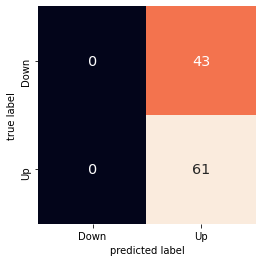

In [45]:
mat = pd.DataFrame(confusion_matrix(test_endog, logit_test_preds), columns = ["Down", "Up"], index = ["Down", "Up"])
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"})
ax.set(xlabel = "predicted label", ylabel = "true label");

In [47]:
(logit_test_preds == df.loc[~train_mask, "Direction"]).mean()

0.5865384615384616

As we can see, the results with logistic regression aren't particularly encouraing, as with a prediction threshold of 50% this method was equivalent to always predicting that the market would go up when evaluated on the test set. In addition, the p-value for the coefficient of weighted_lag_avg is 0.599, which means that there isn't evidence to say that it is statistically significant. Thinking a little more about the idea of using a weighted average, it makes sense that the performance with logistic regression won't provide an improvement over what we did in Part 4, since the weighted average is still a linear combination of the variables. We already saw that in a logistic regression model, Lag2 was the only statistically significant coefficient, and even then it is borderline at the 5% significance level, so the weighted average includes variables which we already had reason to believe weren't particularly helpful in making a strong model. I'll still try out the remaining methods with weighted_lag_avg before trying out one other combination of the predictors. Next up is linear discriminant analysis.

**LDA**

In [48]:
# First separate out the training and test sets
X_train = df.loc[train_mask, "weighted_lag_avg"].to_frame()
y_train = df.loc[train_mask, "Direction"]
X_test = df.loc[~train_mask, "weighted_lag_avg"].to_frame()
y_test = df.loc[~train_mask, "Direction"]

# Fit the LDA model using the training set
lda_clf = LDA()
lda_clf.fit(X_train, y_train)

LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

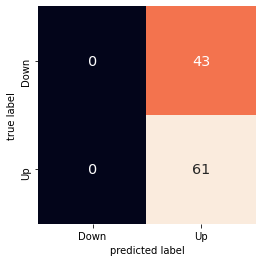

In [49]:
y_pred = lda_clf.predict(X_test)
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = lda_clf.classes_, yticklabels = lda_clf.classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [50]:
lda_clf.score(X_test, y_test)

0.5865384615384616

Linear discriminant analysis has the same performance as logistic regression. This is reasonable since the two methods often perform similarly. Now we'll consider quadratic discriminant analysis.

**QDA**

In [53]:
# First separate out the training and test sets
X_train = df.loc[train_mask, "weighted_lag_avg"].to_frame()
y_train = df.loc[train_mask, "Direction"]
X_test = df.loc[~train_mask, "weighted_lag_avg"].to_frame()
y_test = df.loc[~train_mask, "Direction"]

# Fit the QDA model using the training set
qda_clf = QDA()
qda_clf.fit(X_train, y_train)

QuadraticDiscriminantAnalysis(priors=None, reg_param=0.0,
                              store_covariance=False, tol=0.0001)

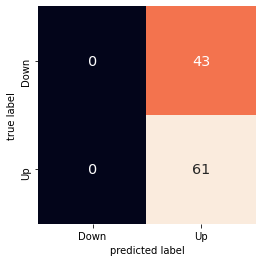

In [54]:
y_pred = qda_clf.predict(X_test)
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = qda_clf.classes_, yticklabels = qda_clf.classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [55]:
qda_clf.score(X_test, y_test)

0.5865384615384616

In [56]:
qda_clf.predict_proba(X_test).max()

0.9435257061804726

Quadratic discriminant analysis also performed the same, but when checking the maximum value in the n-dimensional array of posterior probabilities, I noticed that the maximum probability from QDA is 0.943. This means that it could be meaningful to try out a stricter threshold for predicting an up week. I will try out a threshold of 60%.

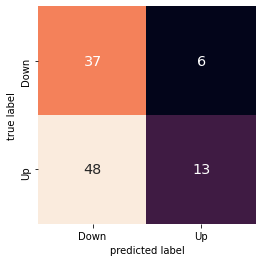

In [57]:
qda_predict_proba = qda_clf.predict_proba(X_test)
# Columns in the 2-dimensional array qda_predict_proba correspond to posterior probabilities
# for the classes, as found in qda_clf.classes_
# In this case, qda_clf.classes_ is the list ["Down", "Up"], so the index 1 column contains the 
# posterior probabilities for the class "Up"
y_pred_60 = pd.Series(qda_predict_proba[:, 1]).apply(lambda x: "Up" if (x > 0.6) else "Down")
mat = confusion_matrix(y_test, y_pred_60)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = qda_clf.classes_, yticklabels = qda_clf.classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [58]:
(y_pred_60.values == y_test.values).mean()

0.4807692307692308

With a somewhat stricter probability threshold of 60% for predicting an up week, we see that our overall prediction accuracy goes down to 48.1%. However, our false positive rate is now  6/43≈0.14 , which is a big improvement over the false positive rate of 1 from Part 6. In addition, our positive predictive value is  13/19≈0.684 , which is also an improvement over the value of 0.587 from Part 6. This suggests that if we are risk-averse investors who only want to invest our money when there is a pretty good chance of the market going up, then QDA with our weighted average of the lag variables and a stricter probability threshold could be promising. Last up is  k -nearest neighbors.

**KNN (K = 1)**

In [59]:
# First separate out the training and test sets
X_train = df.loc[train_mask, "weighted_lag_avg"].to_frame()
y_train = df.loc[train_mask, "Direction"]
X_test = df.loc[~train_mask, "weighted_lag_avg"].to_frame()
y_test = df.loc[~train_mask, "Direction"]

# Set NumPy random seed for consistency and reproducibility of our results
np.random.seed(312)

# Fit the KNN model using the training set
knn_1_clf = KNeighborsClassifier(n_neighbors = 1)
knn_1_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

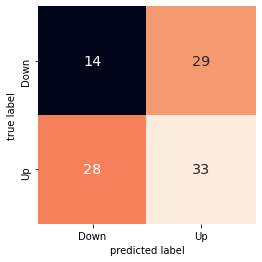

In [60]:
y_pred = knn_1_clf.predict(X_test)
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = qda_clf.classes_, yticklabels = qda_clf.classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [61]:
knn_1_clf.score(X_test, y_test)

0.4519230769230769

With  k=1 , KNN performs even worse than random guessing when it comes to overall prediction accuracy, and the true positive rate (0.541), false positive rate (0.674), and positive predictive rate (0.532) aren't encouraging when compared to the result from Part 8. Before moving on, let's try out two more values for  k :  k=3  and  k=5 .

**KNN (K = 3)**

In [62]:
# Set NumPy random seed for consistency and reproducibility of our results
np.random.seed(312)

# Fit the KNN model using the training set
knn_3_clf = KNeighborsClassifier(n_neighbors = 3)
knn_3_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

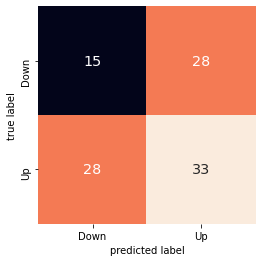

In [63]:
y_pred = knn_3_clf.predict(X_test)
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = qda_clf.classes_, yticklabels = qda_clf.classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [64]:
knn_3_clf.score(X_test, y_test)

0.46153846153846156

**KNN (K = 5)**

In [65]:
# Set NumPy random seed for consistency and reproducibility of our results
np.random.seed(312)

# Fit the KNN model using the training set
knn_5_clf = KNeighborsClassifier(n_neighbors = 5)
knn_5_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

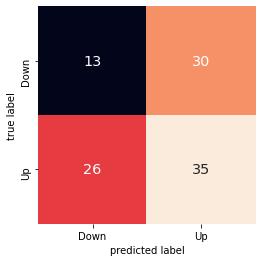

In [66]:
y_pred = knn_5_clf.predict(X_test)
mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(mat, annot = True, cbar = False, ax = ax, fmt = "g", square = True, annot_kws = {"fontsize": "x-large"},
           xticklabels = qda_clf.classes_, yticklabels = qda_clf.classes_)
ax.set(xlabel = "predicted label", ylabel = "true label");

In [67]:
knn_5_clf.score(X_test, y_test)

0.46153846153846156

Even when we increase the value of  k , the results are largely the same. While it would be best to compare these different models using additional tools, such as computing ROC curves and AUC scores for each model, I'll save that for Chapter 9 when we discuss how to produce them in R more in depth. For now, it looks like as far as using weighted_lag_avg to make predictions goes, the most-promising model is QDA with a prediction threshold of 60%.

If I have time to revisit this exercise in the future, I think it would be intersting to try out a different weighting strategy, where each lag variable is weighted based on the number of shares during the corresponding week of trading.